# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

Lominy, Michel, 2074487

OURAHMOUNE, Mahdi, 2083329

Note finale :

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [79]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [81]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [82]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

In [83]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : (measure/f(size))
        for size, measure in measures.items()
    }


def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

In [87]:
def skyline_bruteforce(buildings):
    # TODO : Implantez un algorithme naïf
    skyline = []
    points = []
    for building in buildings:
        points.append(building[0])
        points.append(building[1])

    # Trier la liste selon les coord x
    points = sorted(points)
    hauteurPrec = None
    for point in points:
        hauteur = 0 
        for building in buildings:
            if building[0] <= point < building[1]:
                hauteur = max(hauteur, building[2])
        if(hauteurPrec == None or hauteur != hauteurPrec):
            skyline.append((point, hauteur))
            hauteurPrec = hauteur 

    return skyline


verification_plot(example_buildings, skyline_bruteforce(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

$$
\text{Première Boucle (Tous les cas)} \in \Theta(n)
$$

$$
\text{Seconde Boucle (Méthode sorted de Python en TimSort) (Cas moyen)} \in \Theta(n \log n)
$$

$$
\text{Dernière Boucle} \in \Theta(2n^2) \text{ en prenant } c = 2
$$

$$
\text{Donc: } \Theta(n + n \log n + 2n^2) = \Theta(\max(n, n \log n, 2n^2)) = \Theta(2n^2) = \Theta(n^2)
$$


### Mesures

In [75]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2074487, [1000, 2000, 4000, 6000, 8000, 12000])

In [76]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [77]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
1000         0.12973394393920898
2000         0.3594025135040283
4000         1.5841405391693115
6000         3.3572808742523192
8000         5.9607635021209715
12000        13.404441118240356


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

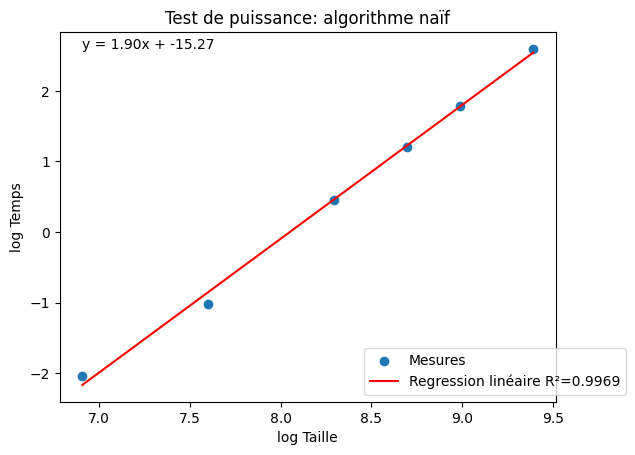

In [78]:
display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

On voit premierement que le taux de croissance de notre algorithme naif est polynomial, puisque les points suivent bien la droite.
De plus, l'analyse de puissance révèle un indice sur le degré de cette croissance, estimé à $a = 1.90$. Cette valeur se rapproche de celle obtenue pour la complexité asymptotique théorique ($\Theta(n^2)$).

Ainsi, la croissance de notre algorithme est effectivement polynomialede degré 2.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

In [79]:
# TODO: definissez f judicieusement
def f(x):
    return math.pow(x, 2)

display_test_rapport(values_test_rapport(measures_bruteforce, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

À travers le test de puissance et l'analyse de la complexité théorique asymptotique, nous avions comme hypothèse que le taux de croissance de l'algorithme naif était de $n^{2}$. Donc, nous avons choisi cette fonction: $f = x^{2}$.

L'observation de la courbe démontre une convergence vers une valeur approchant $0.95e-07$ à l'infini. Ainsi, le test du rapport confirme notre hypothèse.

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

In [80]:
# TODO: définissez f judicieusement
def f(x):
    return math.pow(x, 2)

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le test des constantes vient, ici aussi, confirmer l'hypothèse  que le taux de croissance s'apparente a f. Aussi, il nous permet d'obtenir la valeur exacte de la constante multiplicative: $0.928e-07$

L'analyse hybride nous donne donc la relation entre le temps et la taille de l'exemplaire comme étant: $ f(x) =  0.928e-07 * x^{2}$ 


## Partie 2 : Algorithme diviser pour régner (5 pts)


<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

In [84]:
def skyline_divide_and_conquer(buildings):
    skyline = []
    output = []

    if(len(buildings) == 1):
        return [(buildings[0][0], buildings[0][2]), (buildings[0][1], 0)]

    halfBuildingLength = len(buildings)//2
    skyline_a = skyline_divide_and_conquer(buildings[:halfBuildingLength])
    skyline_b = skyline_divide_and_conquer(buildings[halfBuildingLength:])

    hauteur_a = hauteur_b = 0

    i = j = 0
    while(i < len(skyline_a) and j < len(skyline_b)):
        x_a, h_a = skyline_a[i]
        x_b, h_b = skyline_b[j]
        if x_a < x_b:
            hauteur_a = h_a
            x = x_a
            i += 1
            skyline.append((x, max(hauteur_a, hauteur_b)))
        elif x_a > x_b:
            hauteur_b = h_b
            x = x_b
            j += 1
            skyline.append((x, max(hauteur_a, hauteur_b)))
        elif h_a > h_b:
            hauteur_a = h_a
            x = x_a
            i += 1
            skyline.append((x, hauteur_a))
            if(h_b == 0):
                hauteur_a = 0
                j += 1
        else:
            hauteur_b = h_b
            x = x_b
            j += 1
            skyline.append((x, hauteur_b))
            if(h_a==0):
                hauteur_b = 0
                i += 1

    if i < len(skyline_a):
        skyline = skyline + skyline_a[i:]
    elif j < len(skyline_b):
        skyline = skyline + skyline_b[j:]

    last_h = -1
    for x, h in skyline:
        if h != last_h:
            output.append((x,h))
            last_h = h


    return output
verification_plot(example_buildings, skyline_divide_and_conquer(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

$$
\text{Selon le théorème général: } T(n)= \textit{l}*T(n/b) + cn^k
$$

$$
\text{Dans notre cas, la taille de la liste de batiments est deux fois plus petite à chaque récursion. Ainsi, } b = 2
$$

$$
\text{On éxecute chaque niveau de récursion 2 fois, donc } \textit{l} = 2
$$

$$
\text{Étant donné que chaque appel récursive retourne une liste de \textit{2n} points, alors les boucles qui suivent feront \textit{2n} éxécutions dans tous les cas. Ainsi, } c = 2 \hspace{.1cm} {et} \hspace{.1cm} k = 1
$$

$$
\text{Donc, puisque } \textit{l} = b^k \text{, Alors on obtient } \Theta(n^k log(n))
$$

$$
\text{Soit: } \Theta(n log(n)) \text{ puisque } k=1
$$


### Mesures (seuil 1)

In [105]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2074487, [4000, 16000, 32000, 64000, 128000, 256000, 512000, 1024000])

In [92]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)

In [93]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
4000         0.027348423004150392
16000        0.10130982398986817
32000        0.2079836368560791
64000        0.5224524021148682
128000       1.0168659687042236
256000       2.1406464099884035
512000       4.3903741359710695
1024000      9.278226327896117


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

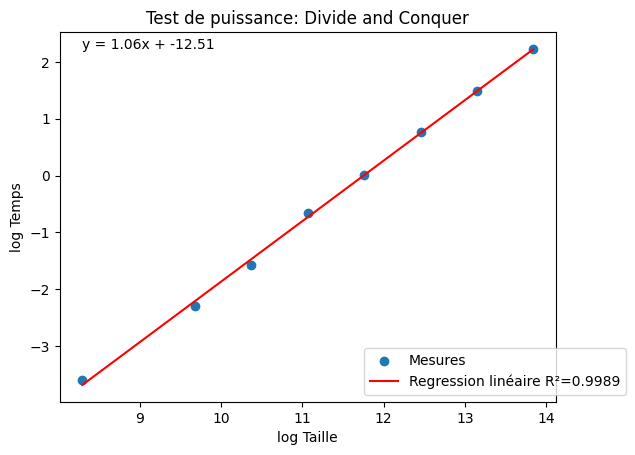

In [95]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: Divide and Conquer")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Selon le test de puissance, on peut voir que nos points suivent une droite. Notre algorithme serait donc hypothétiquement linéaire. Nous savons cependant qu'il ne l'est certainement pas et est plutôt $n\log(n)$. En effet, le test de puissance assume que notre alogrithme est nécessairement polynomial, sub-polynomial ou super polynomial. Il ne peut pas, avec si peu de points, savoir qu'il ne suit en fait pas une droite. Si l'on avait assez de points, on finirait par voir les points diverger de la droite. 

On s'attendrait à obtenir une pente de droite entre $n$ et $n^2$, probablement autour de 1,15. Ici, nous avons cependant obtenu 1,06, un résultat étrange. Ceci pourrait être dû à un mauvais échantillon ou encore au choix de notre seuil. 


#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

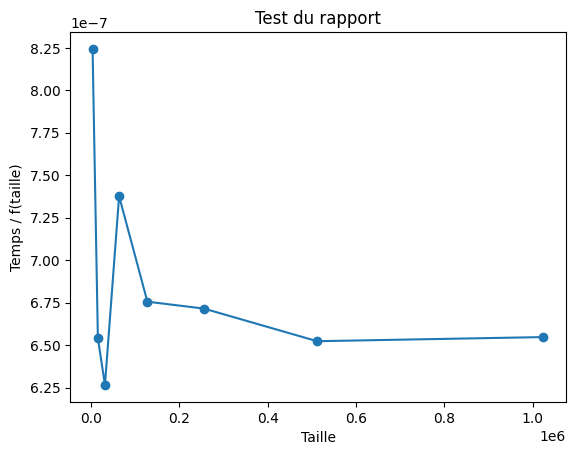

In [96]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Notre hypothèse de fonction f était que notre algorithme suit une croissance nlog(n), donc notre fonction était: $f = x * log(x)$.
Le graphique obtenu par le test du rapport confirme notre hypothèse. En effet, à l'infinie, la courbe converge vers une valeur autour de $6.5e-07$

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

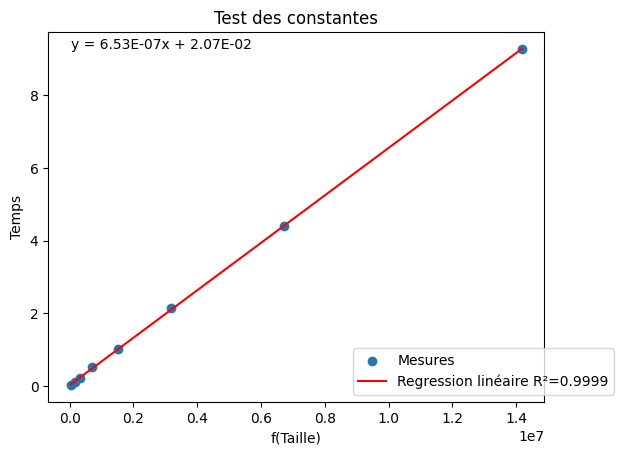

In [97]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le test des constantes vient aussi confirmer que le taux de croissance s'apparente a nlogn (notre hypothèse). Aussi, il nous permet d'obtenir la valeur exacte de la constante multiplicative: $6.53e-07$

On a donc: $ f(x) =  6.53e-07 * x * log(x)$ 

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

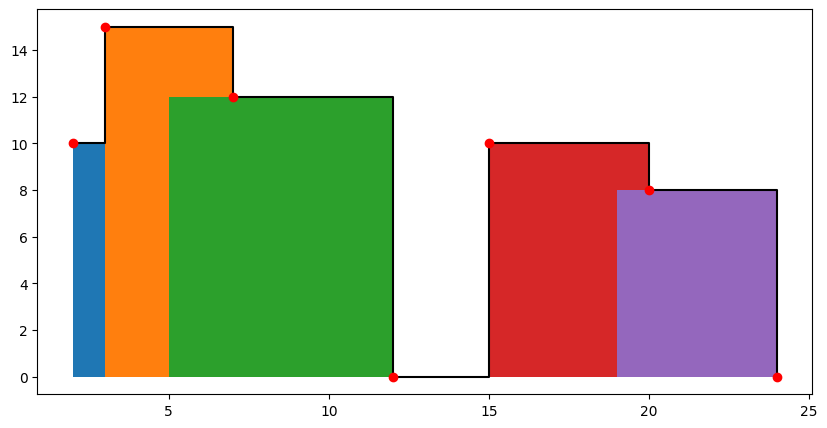

In [90]:
def skyline_divide_and_conquer_threshold(buildings, threshold=1):
    skyline = []
    output = []

    if(len(buildings) <= threshold):
        return skyline_bruteforce(buildings)

    halfBuildingLength = len(buildings)//2
    skyline_a = skyline_divide_and_conquer_threshold(buildings[:halfBuildingLength], threshold)
    skyline_b = skyline_divide_and_conquer_threshold(buildings[halfBuildingLength:], threshold)

    hauteur_a = hauteur_b = 0

    i = j = 0
    while(i < len(skyline_a) and j < len(skyline_b)):
        x_a, h_a = skyline_a[i]
        x_b, h_b = skyline_b[j]
        if x_a < x_b:
            hauteur_a = h_a
            x = x_a
            i += 1
            skyline.append((x, max(hauteur_a, hauteur_b)))
        elif x_a > x_b:
            hauteur_b = h_b
            x = x_b
            j += 1
            skyline.append((x, max(hauteur_a, hauteur_b)))
        elif h_a > h_b:
            hauteur_a = h_a
            x = x_a
            i += 1
            skyline.append((x, hauteur_a))
            if(h_b == 0):
                hauteur_a = 0
                j += 1
        else:
            hauteur_b = h_b
            x = x_b
            j += 1
            skyline.append((x, hauteur_b))
            if(h_a==0):
                hauteur_b = 0
                i += 1

    if i < len(skyline_a):
        skyline = skyline + skyline_a[i:]
    elif j < len(skyline_b):
        skyline = skyline + skyline_b[j:]

    last_h = -1
    for x, h in skyline:
        if h != last_h:
            output.append((x,h))
            last_h = h


    return output

verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, 3))

<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

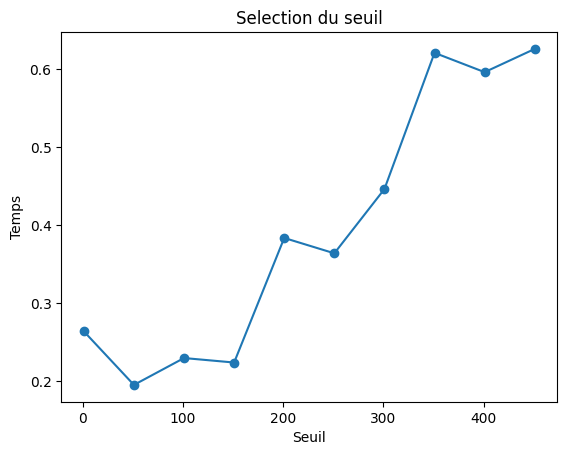

In [95]:
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        [generate_sample(20000)]) # TODO: sélectionnez un exemplaire 
        for i in range(1, 500, 50) # TODO: testez une liste judicieuse de seuils
}
display_mesures_seuil(measures_threshold)

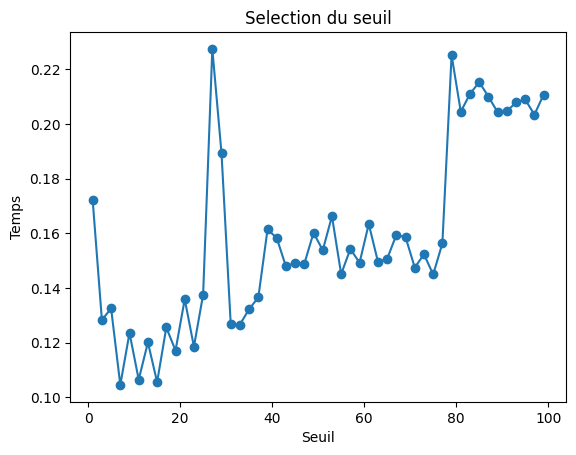

In [96]:
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        [generate_sample(20000)]) # TODO: sélectionnez un exemplaire 
        for i in range(1, 100, 2) # TODO: testez une liste judicieuse de seuils
}
display_mesures_seuil(measures_threshold)

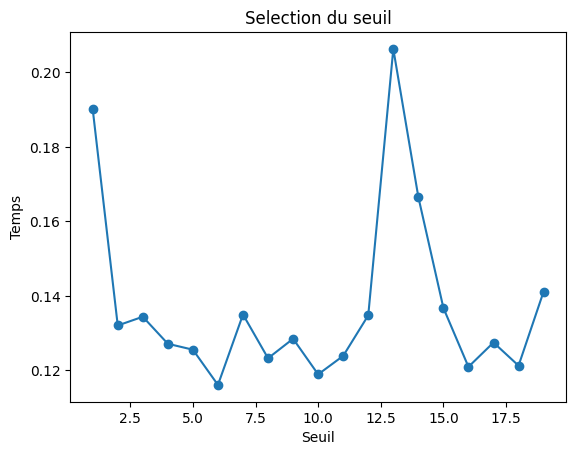

In [102]:
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        [generate_sample(20000)]) # TODO: sélectionnez un exemplaire 
        for i in range(1, 20, 1) # TODO: testez une liste judicieuse de seuils
}
display_mesures_seuil(measures_threshold)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

On observe sur le graphique que le temps le plus bas et la taille d'éléments la plus haute est obtenu avec un seuil de 6. 

Les moins bonnes performances de la part des plus petits seuils viennent du fait que l'algorithme naif est plus performant 

que l'algo récursif qui merge les listes de buildings pour de petites tailles de listes.

De la même manière, les plus gros seuils utilisent l'algo naif pour des tailles de liste où l'algoritme récursif aurait mieux performé. 


Pour sélectionner le seuil de récursivité optimal, nous avons procédé par étapes. Tout d'abord, nous avons effectué un test sur un large intervalle de seuils, allant de 1 à 500, avec des écarts significatifs entre les valeurs de seuil (par pas de 50). Ensuite, nous avons répété cette procédure sur un intervalle plus restreint, de 1 à 100, en diminuant l'écart entre les seuils (par pas de 2). Enfin, pour affiner davantage nos résultats, nous avons effectué une dernière série de tests sur un intervalle encore plus étroit [1, 20], en utilisant des pas de 1.  


Pour nous donner une idée du premier intervalle de seuils à analyser experimentalement, nous avons utilisé le calcul suivant:

De par l'analyse hybride on sait que:

$$
\text{Algo Naif: } y_1 = 0.928e-07 * n^{2}
$$

$$
\text{Divide and conquer: } y_2 = 6.53e-07 * n\log(n)
$$

Ainsi, l'intersection de ses 2 courbes (autre que l'origine):   
$$
0.928e-07 * n^{2} = 6.53e-07 * n\log(n)
$$

$$
\Rightarrow n \approx 37
$$

Donc le seuil optimal devrait se retrouver autour de 37, un résultat très différent du résultat expérimental obtenu. Cela peut être du à certaines implémentations spécifiques de Python, à la machine sur laquelle le code a été éxécuté ou encore simplement aux échantillons générés. 

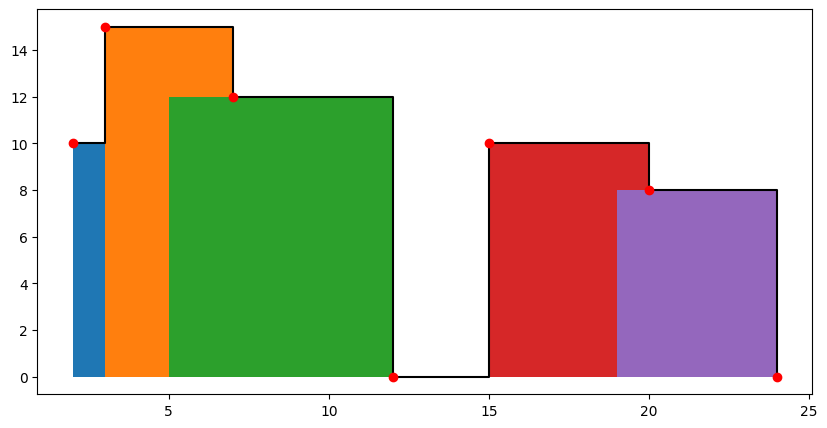

In [103]:
best_threshold = 6
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

$$
\text{Le seuil de récursivité n'affecte pas la complexité puisque l'algorithme de brute force n'est utilisé que pour}  
$$

$$
\text{n < seuil (6 dans notre cas)}
$$

$$
\text{Or, puisqu'on la complexité dit simplement } \exists n_0 \in \R, \forall n \geqslant n_0 \text{, il suffit simplement de placer } n_0=seuil
$$

$$

$$

$$
\text{Ainsi, selon le théorème général: } T(n)= \textit{l}*T(n/b) + cn^k
$$

$$
\text{Dans notre cas, la taille de la liste de batiments est deux fois plus petite à chaque récursion. Ainsi, } b = 2
$$

$$
\text{On éxecute chaque niveau de récursion 2 fois, donc } \textit{l} = 2
$$

$$
\text{Étant donné que chaque appel récursive retourne une liste de \textit{2n} points, alors les boucles qui suivent feront \textit{2n} éxécutions dans tous les cas. Ainsi, } 
$$

$$
c = 2 \hspace{.1cm} {et} \hspace{.1cm} k = 1
$$

$$
\text{Donc, puisque } \textit{l} = b^k \text{, Alors on obtient } \Theta(n^k log(n))
$$

$$
\text{Soit: } \Theta(n log(n)) \text{ puisque } k=1
$$

### Mesures (seuil n)

In [106]:
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [107]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
4000         0.03695664405822754
16000        0.10106072425842286
32000        0.1889585494995117
64000        0.4252711296081543
128000       0.8823662757873535
256000       1.9107589721679688
512000       4.161929273605347
1024000      9.02621669769287


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

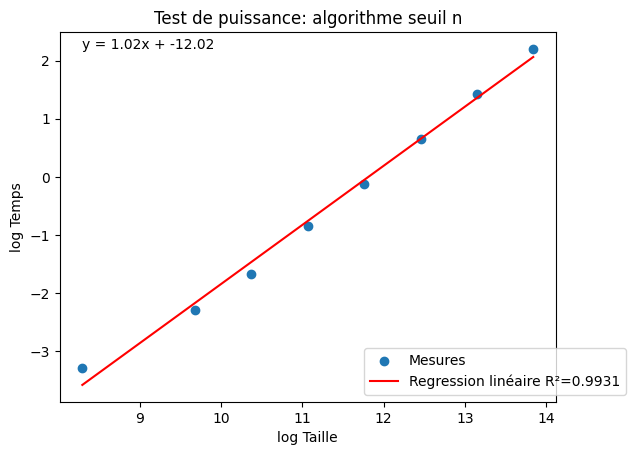

In [108]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Selon le test de puissance, on peut voir que nos points suivent une droite. Notre algorithme serait donc hypothétiquement linéaire. Nous savons cependant qu'il ne l'est certainement pas et est plutôt $n\log(n)$. En effet, le test de puissance assume que notre alogrithme est nécessairement polynomial, sub-polynomial ou super polynomial. Il ne peut pas, avec si peu de points, savoir qu'il ne suit en fait pas une droite. Si l'on avait assez de points, on finirait par voir les points diverger de la droite. 

On s'attendrait à obtenir une pente de droite entre $n$ et $n^2$, probablement autour de 1,15. Ici, nous avons cependant obtenu 1,02, un résultat étrange. Ceci pourrait être dû à un mauvais échantillon ou encore au choix de notre seuil. 


#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

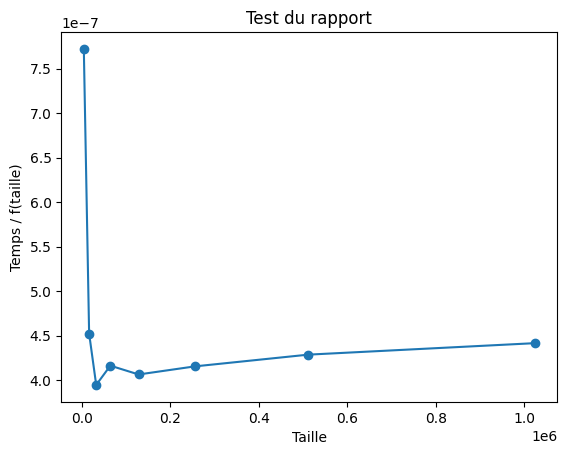

In [109]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x, 2)

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Notre hypothèse de fonction f était que notre algorithme suit une croissance $n \log(n)$, donc notre fonction était: $f = x * log(x)$.
Le graphique obtenu par le test du rapport confirme notre hypothèse. En effet, à l'infinie, la courbe converge vers une valeur légérement sous $4.5e-07$.

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

In [111]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x, 2)

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le test des constantes vient aussi confirmer que le taux de croissance s'apparente à $n \log(n)$ (notre hypothèse). Aussi, il nous permet d'obtenir la valeur exacte de la constante multiplicative: $4.41e-07$

On a donc: $ f(x) =  4.41e-07 * x * log(x)$ 

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Le seuil de récursivité représente la nombre d'éléments après lequel il est plus efficace d'user de l'algorithme diviser-pour-régner et avant lequel il est plus rapide d'utiliser l'algorithme naif. Il est, en théorie, l'endroit ou les complexités des deux algorithmes se rencontres. Celui que nous avons obtenu en pratique est différent de celui théorique. Cela peut être du à certaines implémentations spécifiques de Python, à la machine sur laquelle le code a été éxécuté ou encore simplement aux échantillons générés. 

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

Nous avons appris que le test de puissance ne permet pas d'analyser tous les algorithmes et que ses résultats peuvent ainsi être biaisés. Nous avons aussi trouvé que le seuil de récusivité change la performance réelle (ou pratique) d'un alogrithme mais n'affecte aucunement sa complexité asymptotique. En pratique, si nous savons que le nombre de batiments est généralement sous 6 il sera préférable d'utiliser l'algorithme naif. Pour tout autre cas, il serait probablement préférable d'utiliser l'algorithme diviser-pour-régner (sans seuil). Bien qu'il aille la même complexité asymptotique que le second, celui à seuil a semblé performer moins bien selon nos résultats.  

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.